## Wang Buzsaki 1996
Initial working of the Wang Buzsaki model from their paper in 1996, that includes a saddle-node-like bifurcation.

Mod files from model 26997 in ModelDB.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#from neuron import h, gui
from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

import sys
sys.path.insert(1, "../utils/")
import Stimuli

In [2]:
sim_length = 1000

ex_interval = 5
ex_weight = 0.00003

in_interval = 15
in_weight = 0.00005

ex_times = Stimuli.poisson_process_duration(ex_interval, sim_length)
ex_stim = Stimuli.PoissonStim(
    name='ex',
    stim_id='ex',
    interval=ex_interval,
    rev_potential=0,
    weight=ex_weight,
    tau=2,
    seed='na',
    stim_times=ex_times
)


in_times = Stimuli.poisson_process_duration(in_interval, sim_length)
in_stim = Stimuli.PoissonStim(
    name='in',
    stim_id='in',
    interval=in_interval,
    rev_potential=-80,
    weight=in_weight,
    tau=6,
    seed='na',
    stim_times=in_times
)

In [3]:
class WangBuzsaki:
    def __init__(self):
        self.soma = h.Section()
        
        # initialize the soma's parameters
        self.soma.L = 3.1831
        self.soma.diam = 10
        self.soma.insert(h.pas)
        self.soma.insert(h.kdr)
        self.soma.insert(h.naf)
        self.soma.g_pas = 0.0001
        self.soma.e_pas = -65
        self.soma.gmax_kdr = 0.009
        self.soma.gmax_naf = 0.035
        
        # store stimuli
        self.stim_objects = []
        self.syns = []
        self.syn_currents = []
        self.stims = []
        self.netcons = []
        
        # setup simulation recording
        self._t = h.Vector().record(h._ref_t, sec=self.soma)
        self._v = h.Vector().record(self.soma(0.5)._ref_v)
        self._m_kdr = h.Vector().record(self.soma(0.5).kdr._ref_m)
        self._h_kdr = h.Vector().record(self.soma(0.5).kdr._ref_h)
        self._h_naf = h.Vector().record(self.soma(0.5).naf._ref_h)
        
        self.spike_times = h.Vector()
        self.nc_self = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc_self.threshold = 0
        self.nc_self.record(self.spike_times)
        
        # initial conditions
        self.v0 = None
        self._m_kdr0 = None
        self._h_naf0 = None
        
    def add_custom_stimulus(self, stimuli):
        # stimuli: PoissonStim class object from Stimuli.py

        # add synapse
        syn = h.ExpSyn(self.soma(0))
        syn.tau = stimuli.tau
        syn.e = stimuli.rev_potential * mV
        syn_current = h.Vector().record(syn._ref_i)

        self.syns.append(syn)
        self.syn_currents.append(syn_current)

        netstims = [h.NetStim() for stim_time in stimuli.stim_times]
        for netstim, stim_time in zip(netstims, stimuli.stim_times):
            netstim.number = 1
            netstim.start = stim_time
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = stimuli.weight
            netcon.delay = 0 * ms

            self.netcons.append(netcon)
        self.stims.extend(netstims)
        # don't need to record stim times as we know when they are happening already
        self.stim_objects.append(stimuli)
        
    def sim_init(self, v0, m0, h0): 
        # initialize simulations with new initial conditions and custom stimuli
        self.v0 = v0
        self._m_kdr0 = m0
        self._h_naf0 = h0

    def do_sim_init(self):
        print('doing sim init')
        for seg in self.soma:
            seg.v = self.v0
            seg.kdr.m = self._m_kdr0
            seg.naf.h = self._h_naf0
            print(seg.v, seg.kdr.m, seg.naf.h)
        print('done with sim init')
            
    def run_simulation(self, sim_length):
        if self.v0:
            fih = h.FInitializeHandler(self.do_sim_init)
        # set the temperature to 37F (the temp for the session used in the original model's paper)
        h.celsius = 37
        
        h.finitialize()
        h.continuerun(sim_length * ms)

In [4]:
wb = WangBuzsaki()
wb.add_custom_stimulus(ex_stim)
wb.add_custom_stimulus(in_stim)

In [5]:
wb.run_simulation(sim_length)

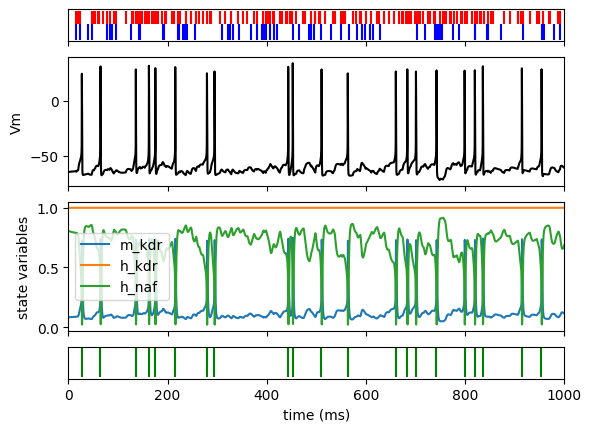

In [6]:
fig, axes = plt.subplots(4,1, sharex=True, gridspec_kw={'height_ratios': [1,4,4, 1]})
axes[0].vlines(ex_times, 0.1,0.9, color='red')
axes[0].vlines(in_times, -.9,0.1, color='blue')
axes[0].set_yticks([])
axes[1].plot(list(wb._t), list(wb._v), c='black')
axes[2].plot(list(wb._t), list(wb._m_kdr))
axes[2].plot(list(wb._t), list(wb._h_kdr))
axes[2].plot(list(wb._t), list(wb._h_naf))
axes[3].vlines(list(wb.spike_times),0.1,.9, color='green')
axes[3].set_yticks([])
axes[1].set_ylabel('Vm')
axes[2].set_ylabel('state variables')
axes[2].legend(['m_kdr', 'h_kdr', 'h_naf'])
axes[-1].set_xlabel('time (ms)')
axes[-1].set_xlim([0,1000])
plt.show()

## generate spiking and median histories

In [7]:
# spiking histories
spike_inds = [round(spike * 40) for spike in list(wb.spike_times)]
spiking_histories = [
    {
        'v':wb._v[spike_ind],
        'm':wb._m_kdr[spike_ind],
        'h':wb._h_naf[spike_ind]
    } for spike_ind in spike_inds]
spiking_histories

[{'v': 4.487085138265703, 'm': 0.3374462980826498, 'h': 0.19869732443187746},
 {'v': 8.250075062674563, 'm': 0.30964759041514556, 'h': 0.25852734373471253},
 {'v': 6.933368023057703, 'm': 0.32378681279047805, 'h': 0.2298589573803623},
 {'v': 0.7907116892321575, 'm': 0.279642902894961, 'h': 0.28849003729280603},
 {'v': 0.36383431990346793, 'm': 0.29506091363065734, 'h': 0.2605049508915958},
 {'v': 8.929852982515582, 'm': 0.31631673411774053, 'h': 0.24745500404945614},
 {'v': 3.7728492711776607, 'm': 0.3322675547446175, 'h': 0.2012368898404478},
 {'v': 0.8188187532617182, 'm': 0.313214607214477, 'h': 0.22584291363781567},
 {'v': 8.39506381501043, 'm': 0.31259602777866724, 'h': 0.252532369526924},
 {'v': 9.122179154509617, 'm': 0.2896103182480009, 'h': 0.30697240159569716},
 {'v': 5.43446710461974, 'm': 0.3151179358374268, 'h': 0.239350843037235},
 {'v': 2.6205660814998772, 'm': 0.3286305345558239, 'h': 0.2036864774186174},
 {'v': 7.227563749262474, 'm': 0.33741384282532894, 'h': 0.206223

In [8]:
# median histories

def standarize_column(column):
    # set column to fit in (0,1)
    column = column-np.min(column)
    column = column/np.max(column)
    return column

def dist(p1, p2):
    # get distance between 2 standardized histories
    return np.sqrt(pow(p1['v']-p2['v'], 2) + pow(p1['m']-p2['m'], 2) + pow(p1['h']-p2['h'], 2))

def get_median_history(sim):
    _v = standarize_column(np.array(sim._v))
    _m = standarize_column(np.array(sim._m_kdr))
    _h = standarize_column(np.array(sim._h_naf))

    # calculate the median of each state variable
    median_values = {
        'v': np.median(_v),
        'm': np.median(_m),
        'h': np.median(_h)
    }
    
    dists = []
    for i in range(len(_v)):
        dists.append(dist({'v':_v[i],'m':_m[i],'h':_h[i]}, median_values))

    return {
            'v': sim._v[np.argmin(dists)],
            'm': sim._m_kdr[np.argmin(dists)],
            'h': sim._h_naf[np.argmin(dists)]
    }

median_history = get_median_history(wb)
median_history

{'v': -62.63896424137329, 'm': 0.10259466539537955, 'h': 0.7298860063700434}

## test setting initial conditions

In [9]:
v0 = -65
m0 = .03
h0 = 0

duration = 100
wb0 = WangBuzsaki()
wb0.sim_init(v0=v0, m0=m0, h0=h0)

wb0.v0

-65

doing sim init
-5.0 0.5 0.0
done with sim init


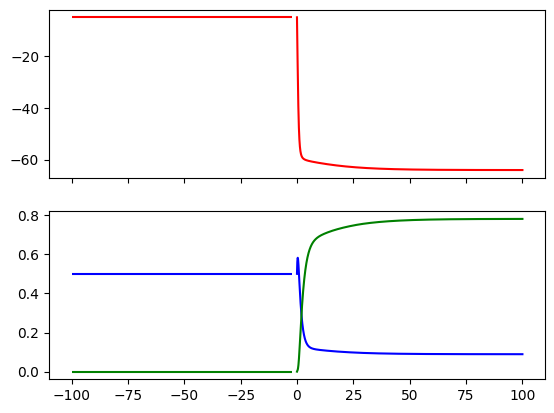

In [10]:
v0 = -5
m0 = .5
h0 = 0

duration = 100
wb0 = WangBuzsaki()
wb0.sim_init(v0=v0, m0=m0, h0=h0)
wb0.run_simulation(duration)

fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(wb0._t, wb0._v, color='red')
axes[0].hlines(v0, -100, -2, color='red')
axes[1].plot(wb0._t, wb0._m_kdr, color='blue')
axes[1].plot(wb0._t, wb0._h_naf, color='green')
axes[1].hlines(m0, -100, -2, color='blue')
axes[1].hlines(h0, -100, -2, color='green')
plt.show()

## run_event_sim
used for nInputs_WB.py

In [11]:
def shift_times(event_times, shift):
    # shifts event times from by the shift amount
    return [event_time + shift for event_time in event_times]

def run_event_sim(events, history, e_w=0.00003, e_t=2, e_rp=0, i_w=0.00005, i_t=6, i_rp=-80, duration=20, robust=False):
    # arguments:
    # events: list of tuples where 0th index has 'event_type':{'e','i','o'} 1st index has 'event_time':(-inf:0]
        # in the case of nInputs.py, the events are all real-valued non-positive times before the current time t=0
    # history: dict with {'v0','m0','h0','n0'}
    # duration: time past t0 for which to continue the simulation
    # robust: False -> returns list of spikes, True -> returns list of spikes and df

    # shift is used to move the times from negative (conceptual model) to positive (NEURON simulation) and back
    shift = -min([event_time for (event_type, event_time) in events])

    # initiate simulation
    sim = WangBuzsaki()

    # add excitatory_stimuli
    e_stim = Stimuli.PoissonStim(
        name='e',
        stim_id='e',
        interval='na',
        rev_potential=e_rp,
        weight=e_w,
        tau=e_t,
        seed='na',
        stim_times=shift_times([event_time for (event_type, event_time) in events if event_type == 'e'], shift)
    )
    sim.add_custom_stimulus(e_stim)
    # add inhibitory_stimuli
    i_stim = Stimuli.PoissonStim(
        name='i',
        stim_id='i',
        interval='na',
        rev_potential=i_rp,
        weight=i_w,
        tau=i_t,
        seed='na',
        stim_times=shift_times([event_time for (event_type, event_time) in events if event_type == 'i'], shift)
    )
    sim.add_custom_stimulus(i_stim)
    # add history
    sim.sim_init(
        v0 = history['v'],
        m0 = history['m'],
        h0 = history['h']
    )
    # run simulation
    sim.run_simulation(sim_length=shift + duration)
    spikes = list(sim.spike_times)
    # shift spikes back
    spikes = shift_times(spikes, -shift)
    if robust:
        return {
            't': list(sim._t),
            'h': list(sim._h),
            'm': list(sim._m),
            'v': list(sim._v),
            'n': list(sim._n)
        }, spikes
    else:
        return spikes

In [12]:
events = Stimuli.excitatory_and_inhibitory_n(ex_interval, in_interval, 10)
# recenter
last_event = events[-1][1]
events = [(event[0], event[1] - last_event) for event in events]
events

[('e', -15.877336133652244),
 ('e', -13.783554413247662),
 ('e', -10.477972429073102),
 ('e', -9.44552005721815),
 ('e', -4.215480843381965),
 ('e', -3.2466325113829804),
 ('e', -0.9387639657754328),
 ('e', -0.8662819510629429),
 ('e', -0.3064948830304388),
 ('e', 0.0)]

In [13]:
run_event_sim(events, median_history)

doing sim init
-62.63896424137329 0.10259466539537955 0.7298860063700434
done with sim init


[-7.852336133552166, 1.5976638664472969]

## Run in NEURON gui

In [14]:

'''# test it on the session from modeldb to make sure it gives the same 
h.load_file('../single.ses')

# turn off the current clamp
h.IClamp[0].amp = 0

# add the expsyn to h.soma'''


"# test it on the session from modeldb to make sure it gives the same \nh.load_file('../single.ses')\n\n# turn off the current clamp\nh.IClamp[0].amp = 0\n\n# add the expsyn to h.soma"

In [15]:
# compare the model specifics between our cell and the session's cell to make sure everything is the same.
# the current clamp needs to be turned off in the session cell.
# the pts3d has a different z position, this is ok

'''h.soma.psection()'''

'h.soma.psection()'